<a href="https://colab.research.google.com/github/KunalVaidya99/Image-Colorization-Using-Deep-Learning/blob/main/Image_Colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [ ]:
import tensorflow as tf
import keras
from keras.layers import (Conv2D,Conv2DTranspose,UpSampling2D,MaxPooling2D,Input
                          ,Activation,Concatenate,BatchNormalization)
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.models import Model
import numpy as np
from keras.preprocessing.image import load_img
from PIL import Image
import os
import random
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint

In [121]:
class DataGenerator(keras.utils.Sequence):
 
  def __init__(self,directory,filenames,batch_size=32,dim=(256,256),n_channels=3,shuffle=True):
    
    self.dim=dim
    self.filenames=filenames
    self.batch_size=batch_size
    self.n_channels=n_channels
    self.shuffle=shuffle
    self.directory=directory
    self.on_epoch_end()
    
 
  def __len__(self):
    return int(np.floor(len(self.filenames)/self.batch_size))
 
  def __getitem__(self,index):
    
    batch_files = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
 
    
 
    X,Y = self.__data_generation(batch_files)
 
    return X,Y
 
  def on_epoch_end(self):
    if self.shuffle == True :
      np.random.shuffle(self.filenames)
 
  def __data_generation(self,batch_files):
 
    X = np.empty((self.batch_size,*self.dim,1))
    Y = np.empty((self.batch_size,*self.dim,self.n_channels))
    count =0 
    
 
    for files in batch_files:
 
     
      image = Image.open(self.directory + "/" + files)
 
      if (np.array(image).shape==(256,256,3)) :
 
        g_image = image
 
        Y[count,] = (np.array(image))/255
 
        X[count,] = (np.expand_dims(np.array(g_image.convert("L")),axis=-1))/255
 
        count = count + 1
 
    return X,Y

In [122]:
directory = "/content/gdrive/My Drive/ImageColorization /val_256/val_256"
filenames = os.listdir(directory)
random.shuffle(filenames)
split_size = 0.1
train_files = filenames[int(split_size*len(filenames)):len(filenames)]
test_files = filenames[:int(split_size*len(filenames))]
TrainGenerator = DataGenerator(directory,train_files)
TestGenerator = DataGenerator(directory,test_files)
img_shape = (256,256,1)

In [123]:
X,Y = TrainGenerator.__getitem__(3)

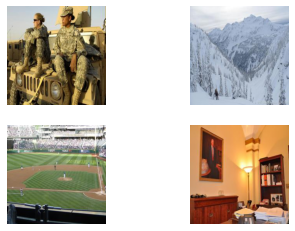

In [124]:
def show_images(n_rows,n_cols):
 
  fig,axs = plt.subplots(nrows=n_rows,ncols=n_cols)
  count = 0
  for i in range(n_rows):
    for j in range(n_cols):
      axs[i,j].imshow(Y[count,:,:])
      axs[i,j].axis('off')
      count = count + 1
 
show_images(2,2)

In [125]:
def downsample(input,filters,kernel_size,strides,padding):
 
  X = Conv2D(filters,kernel_size=kernel_size,strides=strides,padding=padding)(input)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)
  d1 = MaxPooling2D((2,2))(X)
 
  return d1

In [126]:
def upsample(skipinput,input,filters,kernel_size,strides,padding):
 
  concat = Concatenate(axis=-1)([input,skipinput])
  X = Conv2D(filters,kernel_size=kernel_size,strides=strides,padding=padding)(concat)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)
  d1 = UpSampling2D((2,2))(X)
 
  return d1

In [215]:
def ImageColorizer(img_shape):
 
  X_input = Input(shape=img_shape)
 
  d1 = downsample(X_input,64,(3,3),(1,1),"same")
  d2 = downsample(d1,128,(3,3),(1,1),"same")
  d3 = downsample(d2,256,(3,3),(1,1),"same")
  d4 = downsample(d3,512,(3,3),(1,1),"same")
 
 
  u1 = upsample(d4,d4,512,(3,3),(1,1),"same")
  u2 = upsample(d3,u1,256,(3,3),(1,1),"same")
  u3 = upsample(d2,u2,128,(3,3),(1,1),"same")
  u4 = upsample(d1,u3,64,(3,3),(1,1),"same")
 
  out = Conv2D(filters=3,kernel_size=(3,3),padding="same",strides=(1,1))(u4)
  out = BatchNormalization(axis=-1)(out)
  #out = Activation('tanh')(out)
 
  model = Model(inputs=X_input,outputs=out)
 
  return model

In [216]:
ImageColorizer = ImageColorizer(img_shape)
ImageColorizer.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 256, 256, 64) 640         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_28 (BatchNo (None, 256, 256, 64) 256         conv2d_28[0][0]                  
__________________________________________________________________________________________________
activation_27 (Activation)      (None, 256, 256, 64) 0           batch_normalization_28[0][0]     
____________________________________________________________________________________________

In [279]:
def downsample_block(layer_input,filters):

  X = Conv2D(filters,kernel_size=(3,3),padding='same')(layer_input)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)

  X = Conv2D(filters,kernel_size=(3,3),padding='same')(X)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)

  X = MaxPooling2D((2,2))(X)

  return X

In [280]:
def upsample_block(layer_input,skip_input,filters,concat=True):

  #X = UpSampling2D((2,2))(layer_input)
  if(concat==True):
    X = Concatenate(axis=-1)([layer_input,skip_input])
  else:
    X = layer_input  

  X = Conv2D(filters[0],kernel_size=(3,3),padding='same')(X)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)

  X = Conv2D(filters[1],kernel_size=(4,4),padding='same')(X)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)

  X = Conv2DTranspose(filters=filters[1],kernel_size=(4,4),strides=(2,2),padding='same')(X)

  return X

In [281]:
def UNet_generator(img_shape):

  input_img = Input(shape=img_shape)

  d1 = downsample_block(input_img,filters=64)
  
  d2 = downsample_block(d1_pool,filters=128) 
 
  d3 = downsample_block(d2_pool,filters=256)
 
  d4 = downsample_block(d3_pool,filters = 512)
  
  #print(d4_pool.shape)

  #u1 = upsample_block(d,NULL,filters=[1024,512],concat=False)
  u1 = upsample_block(d4,None,filters=[512,256],concat=False)
  #print(u1.shape)
  u2 = upsample_block(u1,d3,filters=[256,128])
  u3 = upsample_block(u2,d2,filters=[128,64])
  u4 = upsample_block(u3,d1,filters=[64,32])

  out = Conv2D(3,kernel_size=(1,1),padding='same')(u4)
  out = BatchNormalization(axis=-1)(out)
  out = Activation("sigmoid")(out)

  model = Model(inputs=input_img,outputs=out)

  return model

In [250]:
unet = UNet_generator(img_shape)
opt = Adam(learning_rate=0.0001)
unet.compile(optimizer=opt,loss="mean_squared_error")


In [252]:
unet.fit_generator(TrainGenerator,validation_data=TestGenerator,epochs=20)

Epoch 1/20
389/389 [==============================] - 750s 2s/step - loss: 0.0175 - val_loss: 0.0386
Epoch 2/20
389/389 [==============================] - 727s 2s/step - loss: 0.0124 - val_loss: 0.0128
Epoch 3/20
389/389 [==============================] - 729s 2s/step - loss: 0.0109 - val_loss: 0.0112
Epoch 4/20
389/389 [==============================] - 729s 2s/step - loss: 0.0099 - val_loss: 0.0083
Epoch 5/20
389/389 [==============================] - 729s 2s/step - loss: 0.0091 - val_loss: 0.0068
Epoch 6/20
389/389 [==============================] - 728s 2s/step - loss: 0.0085 - val_loss: 0.0058
Epoch 7/20
389/389 [==============================] - 728s 2s/step - loss: 0.0080 - val_loss: 0.0056
Epoch 8/20
389/389 [==============================] - 728s 2s/step - loss: 0.0077 - val_loss: 0.0059
Epoch 9/20
389/389 [==============================] - 728s 2s/step - loss: 0.0074 - val_loss: 0.0070
Epoch 10/20
389/389 [==============================] - 729s 2s/step - loss: 0.0072 - val_lo

In [283]:
unet.save_weights("/content/gdrive/My Drive/ImageColorization /Model1.h5")

In [96]:
def preprocess_images(image):
  image = (image + 1)/2
  return image

In [274]:
def show_results(index,select):

  if (select=="train"):
    X,Y = TrainGenerator.__getitem__(3)
  if (select=="test"):
    X,Y = TestGenerator.__getitem__(3)
  
  
  color_image = Y[index]
  #color_image = preprocess_images(color_image)
  grey_image = X[index,:,:,0]
  #grey_image = preprocess_images(grey_image)
  
  predicts = ImageColorizer.predict(X)
  predicted_image = predicts[index]
  #predicted_image = preprocess_images(predicted_image)

  fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(15,15))
  
  axs[0].imshow(grey_image,cmap='gray')
  axs[0].set_title('Greyscale Image')

  axs[1].imshow(color_image)
  axs[1].set_title('Color Image')

  axs[2].imshow(predicted_image)
  axs[2].set_title('Precited Colour Image')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

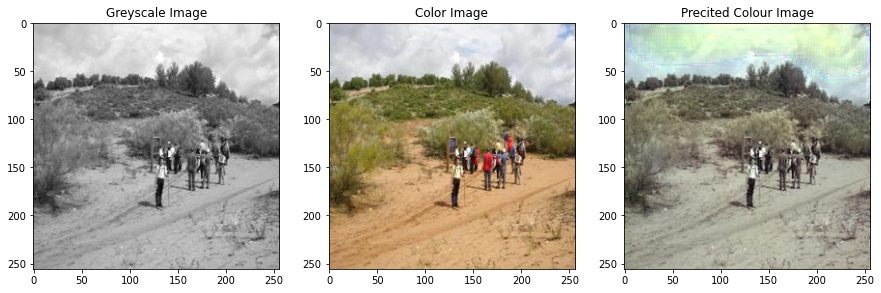

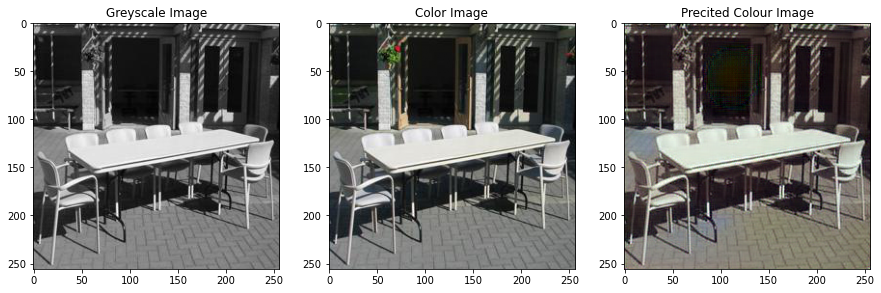

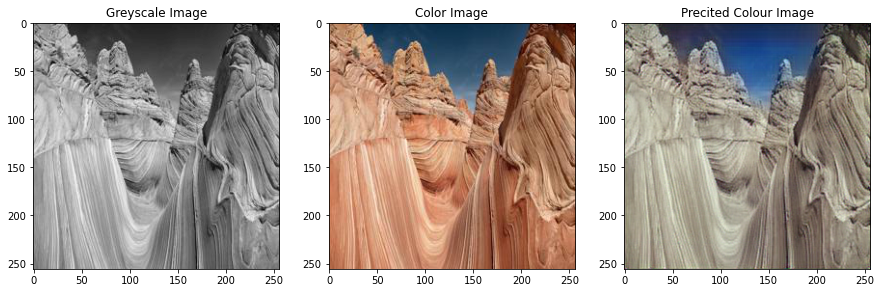

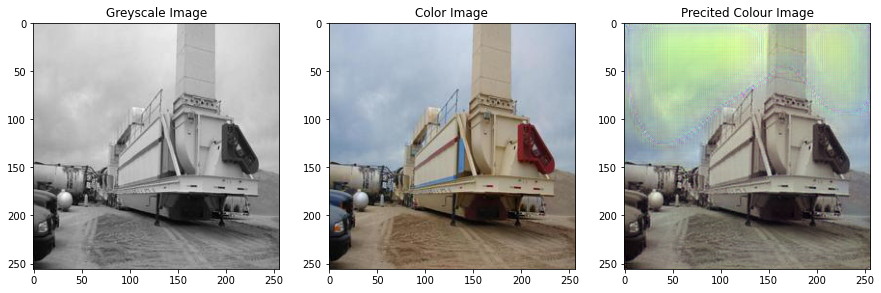

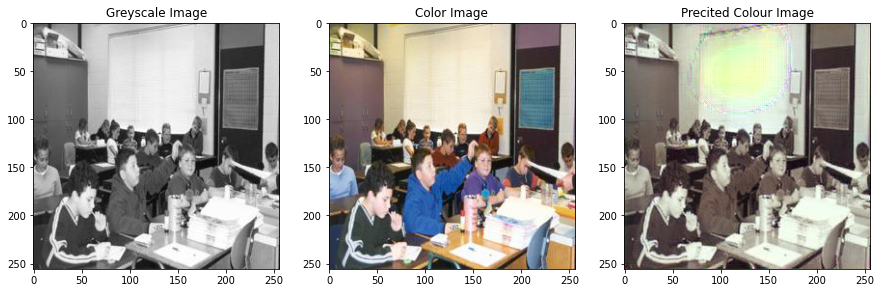

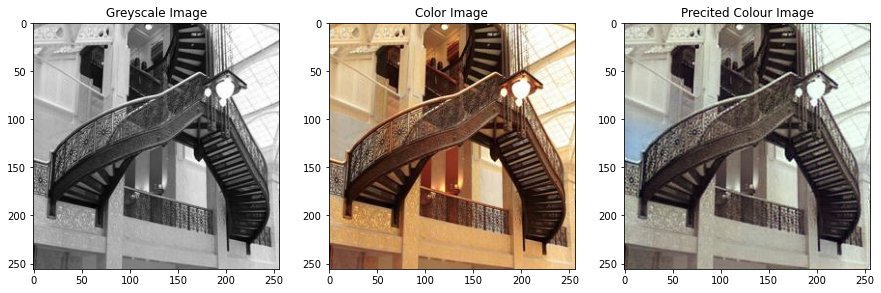

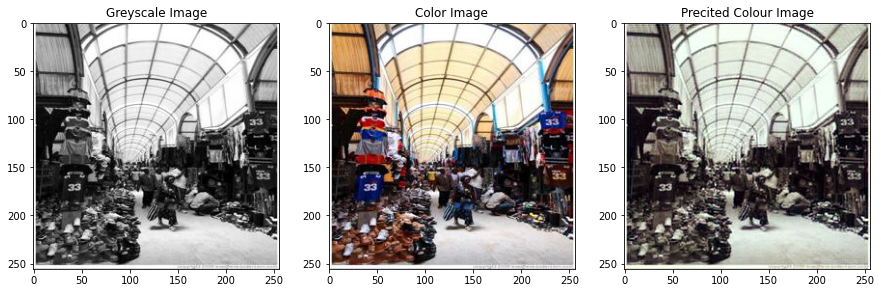

In [284]:
show = 1
for i in range((show-1)*10,10*show):
  show_results(i,"train")

In [260]:
j = unet.predict_generator(TestGenerator)

In [297]:
plt.imshow(j[20])

In [271]:
np.max(j[0])

0.9695016